In [1]:
import pandas as pd
import geopandas as gpd
import folium 
import matplotlib.pyplot as plt
import mapclassify
from census import Census
import requests
import numpy as np
%config InlineBackend.figure_format ='retina'

In [2]:
#2019 food access research atlas data
fara = pd.read_excel('../urabanfarms/FoodAccessResearchAtlasData2019.xlsx', sheet_name='Food Access Research Atlas')
faratx = fara[fara['State'] =='Texas']

In [3]:
faratxsm = faratx[['CensusTract', 'State', 'County', 'Urban', 'Pop2010', 'PovertyRate', 'MedianFamilyIncome', 'LA1and10', 'LATracts_half', 'LATracts1', 'LILATracts_1And10', 'HUNVFlag', 'TractLOWI', 'TractKids', 'TractSeniors', 'TractWhite', 'TractBlack', 'TractAsian', 'TractNHOPI', 'TractAIAN', 'TractOMultir', 'TractHispanic', 'TractHUNV', 'TractSNAP']]

In [4]:
#making it mapable
censustracts = gpd.read_file('../urabanfarms/tl_2019_48_tract.zip')
censustracts['GEOID'] = censustracts['GEOID'].astype(int)
censustracts = gpd.GeoDataFrame(censustracts)

faratxMAP = faratxsm.merge(censustracts, left_on='CensusTract', right_on='GEOID', how='inner')
faratxMAP = gpd.GeoDataFrame(faratxMAP)

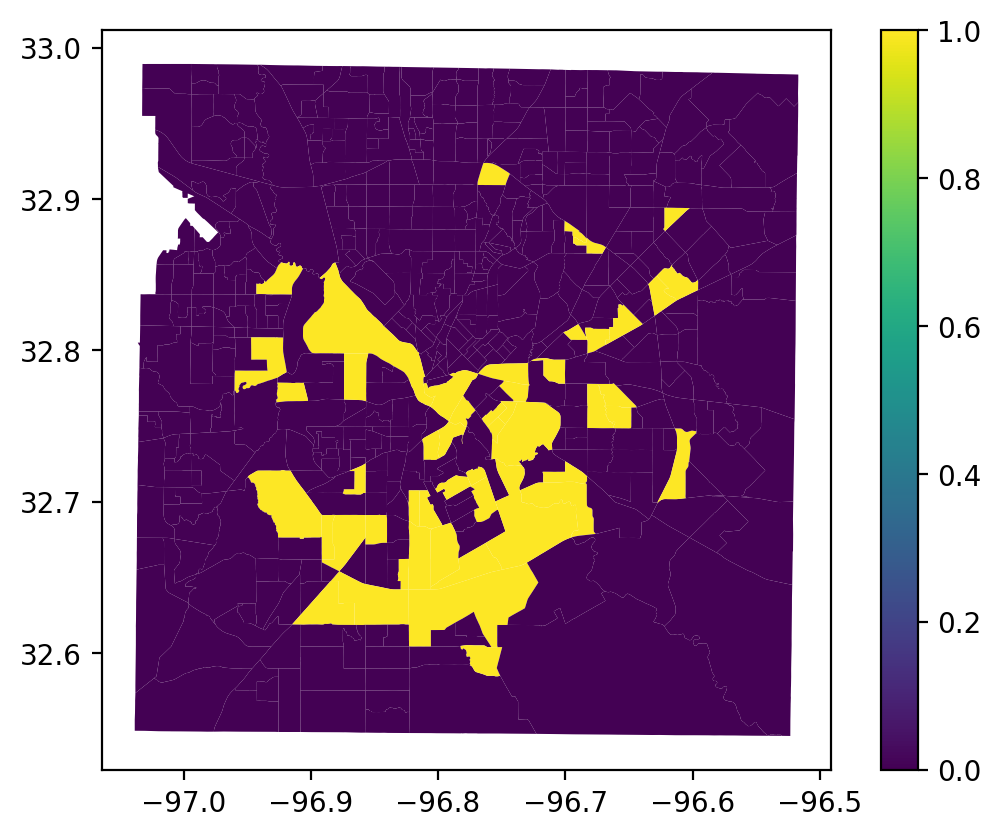

In [5]:
# final food deserts: low income, low access (> 1 mile from a grocery store), low vehicle access (>100 households with no vehicle access greater than 1/2 mile from a grocery store)

faratxMAP['LILA low vehicle'] = faratxMAP['LILATracts_1And10'] & faratxMAP['HUNVFlag']

DallasCounty = faratxMAP[faratxMAP['County'] == 'Dallas County']
DallasCounty.plot('LILA low vehicle', legend = True);

In [6]:
DallasCountyexp = DallasCounty[['CensusTract', 'State', 'County', 'Urban', 'Pop2010', 'PovertyRate', 'MedianFamilyIncome', 'LILATracts_1And10', 'HUNVFlag', 'TractLOWI', 'TractKids', 'TractSeniors', 'TractWhite', 'TractBlack', 'TractAsian', 'TractNHOPI', 'TractAIAN', 'TractOMultir', 'TractHispanic', 'TractHUNV', 'TractSNAP', 'LILA low vehicle', 'geometry']]

DallasCountyexp = DallasCountyexp.rename(columns={'LILATracts_1And10' : 'LILA Tracts',
                      'HUNVFlag' : 'Low Vehicle Access Flag',
                    'LILA low vehicle' : 'LILA Low Vehicle Access'})

In [7]:
DallasCountyexp.to_file('FARADallas.shp')

/tmp/ipykernel_3840921/3049517180.py:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  DallasCountyexp.to_file('FARADallas.shp')


In [6]:
DallasCounty.groupby('LILA low vehicle').sum()

/tmp/ipykernel_687133/3352482394.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  DallasCounty.groupby('LILA low vehicle').sum()


,CensusTract,Urban,Pop2010,PovertyRate,MedianFamilyIncome,LA1and10,LATracts_half,LATracts1,LILATracts_1And10,HUNVFlag,...,TractAsian,TractNHOPI,TractAIAN,TractOMultir,TractHispanic,TractHUNV,TractSNAP,GEOID,ALAND,AWATER
LILA low vehicle,,,,,,,,,,,,,,,,,,,,,
0,22998021068653,470,2118748,7239.208079,38141870.0,126,391,126,41,58,...,115665.0,1123.0,15671.0,390404.0,822314.0,50057.0,93558.0,22998021068653,1933862044,90753675
1,2405650585589,50,249391,1483.913479,2010712.0,50,50,50,50,50,...,3585.0,99.0,1462.0,44069.0,83626.0,13486.0,22792.0,2405650585589,298418262,3115902


In [7]:
# more accurate population data

c = Census('ae76560b57d910bf5513f6d8889b137554e13cd6')

texas21 = c.acs.state_county_tract(fields = ('B01003_001E'),  state_fips='48', county_fips='*', tract="*", year = 2019)
texas21 = pd.DataFrame(texas21)

texas21 = texas21.rename(columns={'B01003_001E' : 'Population'})
texas21['geoid'] = texas21['state'] + texas21['county'] + texas21['tract']
texas21['geoid'] = texas21['geoid'].astype(int)

In [8]:
texas21 = texas21.merge(DallasCounty, left_on='geoid', right_on='GEOID', how='left')

In [9]:
texas21.groupby('LILA low vehicle').sum()

/tmp/ipykernel_687133/3986416848.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  texas21.groupby('LILA low vehicle').sum()


,Population,geoid,CensusTract,Urban,Pop2010,PovertyRate,MedianFamilyIncome,LA1and10,LATracts_half,LATracts1,...,TractAsian,TractNHOPI,TractAIAN,TractOMultir,TractHispanic,TractHUNV,TractSNAP,GEOID,ALAND,AWATER
LILA low vehicle,,,,,,,,,,,,,,,,,,,,,
0.0,2326382.0,22998021068653,2.299802e+13,470.0,2118748.0,7239.208079,38141870.0,126.0,391.0,126.0,...,115665.0,1123.0,15671.0,390404.0,822314.0,50057.0,93558.0,2.299802e+13,1.933862e+09,90753675.0
1.0,280486.0,2405650585589,2.405651e+12,50.0,249391.0,1483.913479,2010712.0,50.0,50.0,50.0,...,3585.0,99.0,1462.0,44069.0,83626.0,13486.0,22792.0,2.405651e+12,2.984183e+08,3115902.0
